## Introduction

The project aims to predict the fatality of a potential shark attack based on predictor variables such as:

- Wound location
- Activity during the attack
- Type of incident
- Victim's age and gender
- Geographical area and a risk categorization assigned to the country based on its fatality ratio
- Size of the shark species responsible for the attack
- Year of the incident

To achieve this prediction, we utilized a logistic regression model and monitored its performance using accuracy, precision, recall, F1 score, and ROC AUC metrics.

In [1]:
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

### Import and settings

In [2]:
import pandas as pd  
from pandas import options
import numpy as np 
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

### Loading the cleaned data

At the project's outset, we gathered to share our dataframes, understanding the different approaches and processes each of us had undertaken. 

Due to disparities in aspects such as NaN management, our datasets had different sizes. 

Therefore, we chose one of the two datasets to proceed with model improvement.

In [4]:
final_df = pd.read_csv(r"c:\Users\USUARIO\Desktop\Data Analysis\Ironhack\Mini-Proyecto\final_df_angel.csv", encoding= "latin1")
final_df = final_df.drop(columns="Unnamed: 0")
final_df.head()

high_risk_zone  low_moderate_risk_zone  low_risk_zone  moderate_risk_zone  \
0             0.0                     0.0            1.0                 0.0   
1             0.0                     0.0            1.0                 0.0   
2             0.0                     0.0            1.0                 0.0   
3             0.0                     0.0            1.0                 0.0   
4             0.0                     0.0            0.0                 1.0   

   california  eastern_cape_province  florida  hawaii  kwazulu-natal  \
0         1.0                    0.0      0.0     0.0            0.0   
1         0.0                    0.0      0.0     0.0            0.0   
2         0.0                    0.0      0.0     1.0            0.0   
3         0.0                    0.0      0.0     0.0            0.0   
4         0.0                    0.0      0.0     0.0            0.0   

   new_jersey  ...  torso  unspecified.1  large_shark  medium_size_shark  \
0         0.0  ...    0.0            0.0          0.0                1.0   
1         0.0  ...    0.0            0.0          0.0                0.0   
2         0.0  ...    0.0            0.0          0.0                0.0   
3         0.0  ...    0.0            0.0          0.0                0.0   
4         0.0  ...    0.0            0.0          0.0                0.0   

   small_shark  unspecified.2    n    y    year   age  
0          0.0            0.0  1.0  0.0  2018.0  57.0  
1          0.0            1.0  1.0  0.0  2018.0  11.0  
2          0.0            1.0  1.0  0.0  2018.0  48.0  
3          1.0            0.0  1.0  0.0  2018.0  31.0  
4          1.0            0.0  1.0  0.0  2018.0  31.0  

[5 rows x 55 columns]

## Starting point: Classification model 

In [5]:
X = final_df.drop(["y", "n", "fatal_unspecified"], axis=1)
y = final_df["y"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [8]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
classification = LogisticRegression(random_state=42)
classification.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [10]:
predictions = classification.predict(X_test_scaled)
predictions

array([0., 0., 1., ..., 0., 0., 0.])

<Axes: >

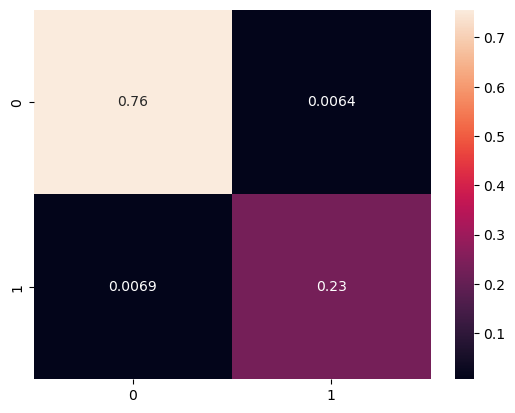

In [11]:
cm = confusion_matrix(y_test, predictions)
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True)

In [12]:
classification.score(X_test, y_test)

0.7625940938042849

In [13]:
precision = precision_score(predictions, y_test)
print("Precision:", precision)

recall = recall_score(predictions, y_test)
print("Recall:", recall)

f1 = f1_score(predictions, y_test)
print("F1-score:", f1)

roc_auc = roc_auc_score(predictions, y_test)
print("ROC-AUC Score:", roc_auc)

Precision: 0.9707317073170731
Recall: 0.9731051344743277
F1-score: 0.9719169719169719
ROC-AUC Score: 0.9820002151886054


## Optimization 

Once establishing the starting point, our focus shifted to optimizing the model, beginning with outlier elimination. 

### Remove outliers

Guided by the interquartile range, we filtered numerical values beyond or below the limit values, extracting them from the final dataset. 

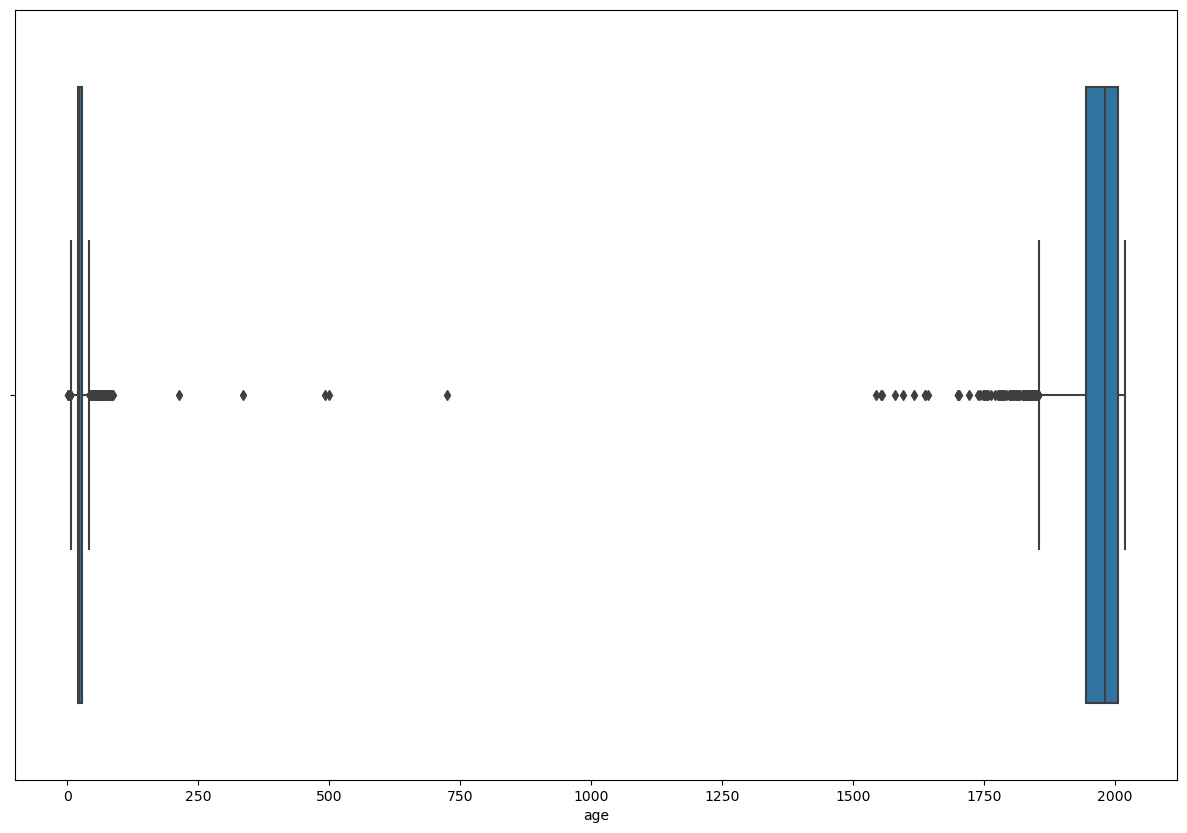

In [14]:
num_df = final_df[["year", "age"]]
plt.figure(figsize=(15,10))
sns.boxplot(data=num_df, x="year")
sns.boxplot(data=num_df, x="age")
plt.show()

In [15]:
# Calculating the interquartile range of year and age

summary = num_df.describe().T
IQR = summary["75%"] - summary["25%"]
left_end = summary["25%"] - 1.5 * IQR
right_end = summary["75%"] + 1.5 * IQR
print(left_end, right_end)

year    1855.0
age        6.5
dtype: float64 year    2095.0
age       42.5
dtype: float64


In [16]:
#Filtering outliers

outliers = final_df[(final_df["year"] <= left_end["year"]) | (final_df["year"] >= right_end["year"]) | (final_df["age"] <= left_end["age"]) | (final_df["age"] >= right_end["age"])]
outliers.head()

high_risk_zone  low_moderate_risk_zone  low_risk_zone  moderate_risk_zone  \
0              0.0                     0.0            1.0                 0.0   
2              0.0                     0.0            1.0                 0.0   
7              0.0                     0.0            1.0                 0.0   
21             0.0                     0.0            1.0                 0.0   
26             0.0                     1.0            0.0                 0.0   

    california  eastern_cape_province  florida  hawaii  kwazulu-natal  \
0          1.0                    0.0      0.0     0.0            0.0   
2          0.0                    0.0      0.0     1.0            0.0   
7          0.0                    0.0      1.0     0.0            0.0   
21         0.0                    0.0      0.0     0.0            0.0   
26         0.0                    0.0      0.0     0.0            0.0   

    new_jersey  ...  torso  unspecified.1  large_shark  medium_size_shark  \
0          0.0  ...    0.0            0.0          0.0                1.0   
2          0.0  ...    0.0            0.0          0.0                0.0   
7          0.0  ...    0.0            0.0          0.0                0.0   
21         0.0  ...    0.0            0.0          0.0                0.0   
26         0.0  ...    0.0            0.0          0.0                0.0   

    small_shark  unspecified.2    n    y    year   age  
0           0.0            0.0  1.0  0.0  2018.0  57.0  
2           0.0            1.0  1.0  0.0  2018.0  48.0  
7           1.0            0.0  1.0  0.0  2018.0  52.0  
21          1.0            0.0  1.0  0.0  2018.0  60.0  
26          1.0            0.0  1.0  0.0  2018.0  54.0  

[5 rows x 55 columns]

In [17]:
# Removing outliers from df

merged_df = final_df.merge(outliers, indicator=True, how='left', on=list(final_df.columns))
filtered_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')
filtered_df = filtered_df.reset_index().drop(columns="index")
num_df.shape[0] - filtered_df.shape[0]

661

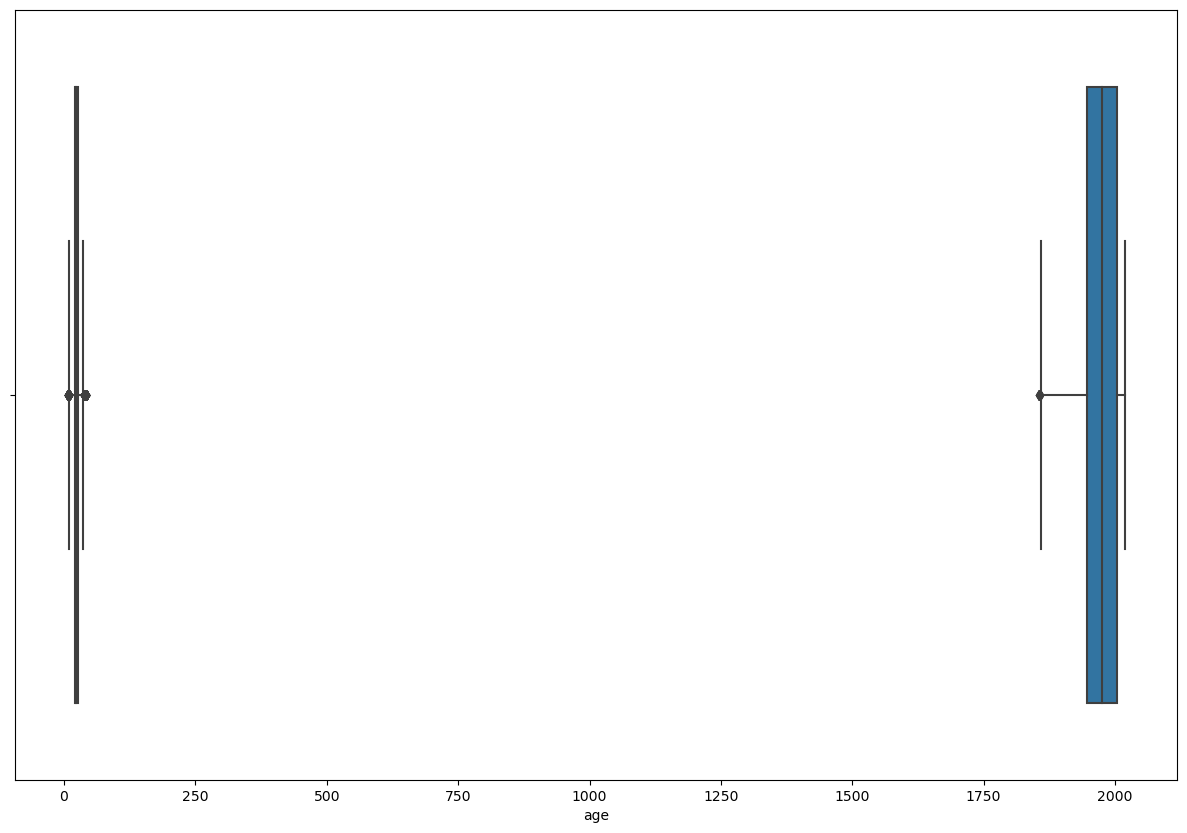

In [18]:
# Checking boxplots

plt.figure(figsize=(15,10))
sns.boxplot(data=filtered_df, x="year")
sns.boxplot(data=filtered_df, x="age")
plt.show()

### Balancing the model

The subsequent step was balancing the values, as there were significantly more negative values than positive ones for the dependent variable. We implemented RandomOverSampler to resample the training data partitions.

In [19]:
# Train-test splitting

X = filtered_df.drop(["y", "n", "fatal_unspecified"], axis=1)
y = filtered_df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [20]:
# Resampling X_train and y_train

sampler = RandomOverSampler(random_state=42)

In [21]:
# Fitting the resampler

X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
y_train_balanced.value_counts()

y
1.0    2727
0.0    2727
Name: count, dtype: int64

In [22]:
#Scaling balanced data

scaler = StandardScaler()
scaler.fit(X_train_balanced)

StandardScaler()

In [23]:
X_train_scaled = scaler.transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

## Final Implementation

After this phase, our intention was to carry out an iterative selection of the best predictor variables based on the backwards selection methodology. 

However, upon monitoring the model's performance following the implemented changes, the results were so positive that we decided against further feature selection.

Finally, we experimented with different scaling methods, ultimately opting for StandardScaler. 

While we can't definitively confirm if the model is overfitting, we are pleased with the achieved results.

In [24]:
classification.fit(X_train_scaled, y_train_balanced)

LogisticRegression(random_state=42)

[[0.76193591 0.00850229]
 [0.00719424 0.22236756]]


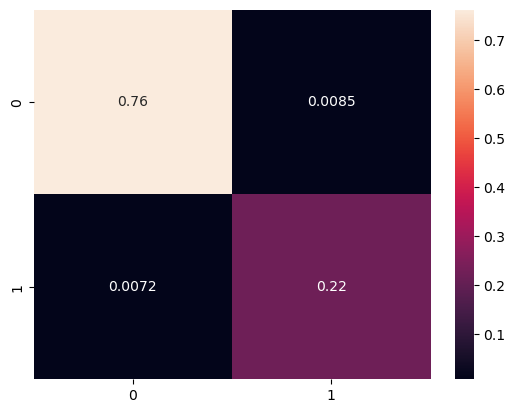

In [25]:
# Representing performance in a confussion matrix

predictions = classification.predict(X_test_scaled)
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True)
print(cf_matrix)

In [26]:
classification.score(X_test_scaled, y_test)

0.9843034663178548

In [27]:
# Trying new metrics to deepen our understanding of the performance of the model

precision = precision_score(predictions, y_test)
print("Precision:", precision)

recall = recall_score(predictions, y_test)
print("Recall:", recall)

f1 = f1_score(predictions, y_test)
print("F1-score:", f1)

roc_auc = roc_auc_score(predictions, y_test)
print("ROC-AUC Score:", roc_auc)

Precision: 0.9686609686609686
Recall: 0.9631728045325779
F1-score: 0.9659090909090909
ROC-AUC Score: 0.9769095315179896
